# Camassa-Holm hyperbolization 

In [1]:
import numpy as np
from nodepy import rk
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
font = {'size'   : 15}
matplotlib.rc('font', **font)

from IPython.display import clear_output
from time import time

fft = np.fft.fft
ifft = np.fft.ifft

In [2]:
# Third order SSPRK(3,3) method 
ssp33 = rk.loadRKM('SSP33').__num__()

In [3]:
# Initial condition
def IC(x):
    u = (np.pi/2)*np.exp(x) - 2*np.sinh(x)*np.arctan(np.exp(x)) - 1
    u[x > 20] = 0  
    return u

## Solution of the original CH equation 

In [4]:

# Right hand side function of the CH equation: This is a direct semidiscretization of the CH equation
def CH_rhs(u, xi, filtr):
    u_t = np.zeros_like(u); S = 1/(1-(1j*xi)**2)
    
    u_t = -3*np.real(ifft(S*fft(u*np.real(ifft(1j*xi*fft(u)))))) + \
          2*np.real(ifft(S*fft(np.real(ifft(1j*xi*fft(u)))*np.real(ifft((1j*xi)**2*fft(u)))))) + \
          np.real(ifft(S*fft(u*np.real(ifft((1j*xi)**3*fft(u))))))
    
    return u_t

# Time stepping method for the CH equation
def CH_ERK(u,xi,rhs,rkm,dt,filtr):
    s = len(rkm)
    g = np.zeros((s,len(u))) 
    R = np.zeros((s,len(u))) 
    for i in range(s):
        g[i,:] = u.copy()
        for j in range(i):
            g[i,:] += dt*rkm.A[i,j]*R[j,:]
        R[i,:] = rhs(g[i,:],xi,filtr)
        inc = sum([rkm.b[i]*R[i] for i in range(s)]) 
        
    u_new = u+dt*inc
    
    return u_new

# This function returns the solution at the final time
def CH_Sol(rhs,xL,xR,m,t0,u0,tmax,ERK_fun,rkm):
    
    L = xR-xL 
    xplot = np.linspace(xL, xR, m+1)
    x = xplot[0:-1]; dx = x[1] - x[0]
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    
    # Initial state vector 
    u = u0(x);
    
    # Time step based on stability
    dt = 1.73/((m/2)**2)
    t = t0
    
    # Use 2/3 filter to avoid aliasing instability 
    filtr = np.ones_like(xi)
    use_filter = True
    if use_filter:
        xi_max = np.max(np.abs(xi))
        filtr[np.where(np.abs(xi)>xi_max*2./3)] = 0.

    # time loop
    t_start = time()
    while t < tmax and not np.isclose(t, tmax):
        clear_output(wait=True)
        if t + dt > tmax:
            dt = tmax - t

        u_new = ERK_fun(u,xi,rhs,rkm,dt,filtr)
        u = u_new.copy();  t+= dt
        print("t = %.2e"%(t))
    
    u_final = u; t_final = t
    
    t_end = time()
    req_t = t_end-t_start  
    
    return req_t, u_final, x, t_final

In [5]:
# Compute solution 
xL = -10; xR = 50; t0 = 0; u0 = IC; tmax = 10; m = 512
rhs = CH_rhs; ERK_fun = CH_ERK; rkm = ssp33

req_t_ref, u_ref, x_ref, t_ref = CH_Sol(rhs,xL,xR,m,t0,u0,tmax,ERK_fun,rkm)

t = 1.00e+01


## Soluton by the approximate CHH equation

In [6]:
# Initial condition for the hyperbolized Camassa Holm system
def Hyp_CH_q0(xL,xR,x,t0):   
    m = len(x); dx = x[1] - x[0]; L = xR - xL
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    q = np.zeros((3,len(x)))
    q[0,:] = IC(x)
    
    # Initial conditions for derivatives v and w from the 
    # function values u using spectral differentiation 
    q[1,:] = np.real(ifft( 1j*xi*fft(q[0,:]) ))
    q[2,:] = np.real(ifft( (1j*xi)**2*fft(q[0,:]) ))
        
    
    return q

# Right hand side function of the hyperbolized CH system
def Hyp_CH_rhs(q, xi, c1, c2,filtr):
    q_t = np.zeros_like(q)
    u = q[0,:]; v = q[1,:]; w = q[2,:]
    
    # RHS 2
    q_t[0,:] = -3*u*np.real( ifft( 1j*xi*fft(u)*filtr ) ) - c2*(np.real( ifft( 1j*xi*fft(u) ) ) - v) + 2*np.real( ifft(1j*xi*fft(u)*filtr ) )*w + u*np.real( ifft( 1j*xi*fft(w)*filtr ) ) 
    q_t[1,:] = -c1*(np.real( ifft( 1j*xi*fft(v) ) ) - w)
    q_t[2,:] = -c2*(np.real( ifft( 1j*xi*fft(u) ) ) -v)


    return q_t

# Time stepping method for the hyperbolized system
def Hyp_CH_ERK(q,xi,c1,c2,rhs,rkm,dt,filtr):
    s = len(rkm)
    g = np.zeros((s, *q.shape)) 
    R = np.zeros((s, *q.shape)) 
    for i in range(s):
        g[i,:] = q.copy()
        for j in range(i):
            g[i,:] += dt*rkm.A[i,j]*R[j,:]
        R[i,:] = rhs(g[i,:],xi, c1, c2,filtr)
        inc = sum([rkm.b[i]*R[i] for i in range(s)]) 
        
    q_new = q+dt*inc
    
    
    return q_new

# This function returns the solution at the final time. 
def Hyp_CH_Sol(rhs,xL,xR,m,t0,q0,tmax,c1,c2,ERK_fun,rkm):
    
    L = xR-xL # Length of the domain
    xplot = np.linspace(xL, xR, m+1)
    x = xplot[0:-1]; dx = x[1] - x[0]
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    
    # Initial state vector 
    q = q0(xL,xR,x,t0)
    
    # Time step based on the CFL number
    u_max = np.max(np.abs(q[0,:]))
    s_max = max(np.abs(c1),np.abs(0.5*(3*u_max+c2+np.sqrt((3*u_max+c2)**2-4*u_max*c2))) )
    print('Maximum speed = %1.2f'%s_max)
    #dt = (mu*dx)/s_max with CFL number = mu and s_max = maximum speed
    mu = 0.173; dt = mu*dx/s_max
    print('CFL based time step = %1.2e'%dt)

    t = t0
    
    # use 2/3 filter to avoid aliasing instability 
    filtr = np.ones_like(xi)
    use_filter = True
    if use_filter:
        xi_max = np.max(np.abs(xi))
        filtr[np.where(np.abs(xi)>xi_max*2./3)] = 0.
    
    while t < tmax and not np.isclose(t, tmax):
        clear_output(wait=True)
        if t + dt > tmax:
            dt = tmax - t

        q_new = ERK_fun(q,xi,c1,c2,rhs,rkm,dt,filtr)
        q = q_new.copy();  t+= dt
        #print("m = %d, c1 = %d, c2 = %d, t = %.2f"%(m, c1, c2, t))
    
    q_final = q; t_final = t
    
    return q_final, x, t_final

In [7]:
# Compute solution 
C_1 = np.array([50,100,150]); C_2 = - C_1

q0 = Hyp_CH_q0; rhs = Hyp_CH_rhs; ERK_fun = Hyp_CH_ERK; rkm = ssp33

In [8]:
c1 = C_1[0]; c2 = C_2[0];
c1_1st_q_f, x, t_f = Hyp_CH_Sol(rhs,xL,xR,m,t0,q0,tmax,c1,c2,ERK_fun,rkm)

In [9]:
c1 = C_1[1]; c2 = C_2[1];
c1_2nd_q_f, x, t_f = Hyp_CH_Sol(rhs,xL,xR,m,t0,q0,tmax,c1,c2,ERK_fun,rkm)

In [10]:
c1 = C_1[2]; c2 = C_2[2];
c1_3rd_q_f, x, t_f = Hyp_CH_Sol(rhs,xL,xR,m,t0,q0,tmax,c1,c2,ERK_fun,rkm)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Plot solution

In [11]:
L = xR - xL; xi = np.fft.fftfreq(m)*m*2*np.pi/L

def spectral_representation(x0,uhat):
    u_fun = lambda y : np.real(np.sum(uhat*np.exp(1j*xi*(y-x0))))/len(uhat)
    u_fun = np.vectorize(u_fun)
    return u_fun

c1_1st_spectral = spectral_representation(xL,fft(c1_1st_q_f[0,:]))
c1_2nd_spectral = spectral_representation(xL,fft(c1_2nd_q_f[0,:])) 
c1_3rd_spectral = spectral_representation(xL,fft(c1_3rd_q_f[0,:])) 
CH_ref_spectral = spectral_representation(xL,fft(u_ref)) 

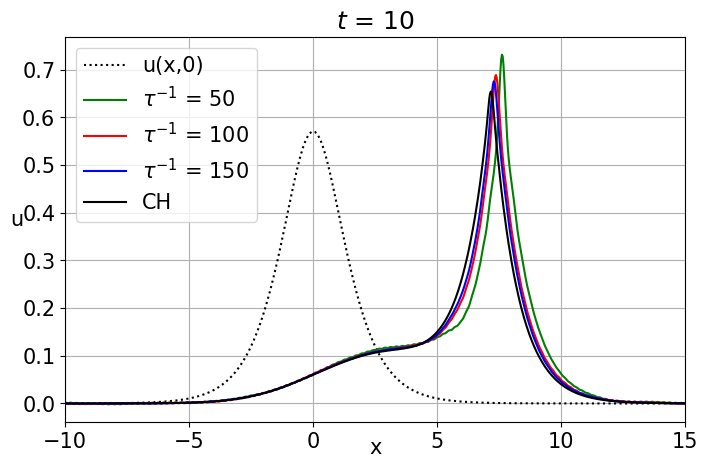

In [15]:
x_fine = np.linspace(x[0],x[-1],2000)

plt.figure(figsize=(8, 5))
plt.plot(x,IC(x),':k',label = 'u(x,0)')
plt.plot(x_fine,c1_1st_spectral(x_fine),'-g',label = r'$\tau^{-1}$ = %d'%C_1[0])
plt.plot(x_fine,c1_2nd_spectral(x_fine),'-r',label = r'$\tau^{-1}$ = %d'%C_1[1])
plt.plot(x_fine,c1_3rd_spectral(x_fine),'-b',label = r'$\tau^{-1}$ = %d'%C_1[2])
plt.plot(x_fine,CH_ref_spectral(x_fine),'-k',label = 'CH')
plt.title('$t$ = %d'%tmax)
plt.xlabel("x", labelpad=-10)
plt.ylabel("u", rotation=0)
plt.xlim(-10, 15)
plt.grid()
plt.legend()
plt.savefig("Hyp_CH_Sol_Comp.pdf")